In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
import random
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as torch_data
from nilearn import plotting
import nibabel as nib
import nilearn
import os
import sys
import pathlib
import functools
from sklearn.model_selection import train_test_split, StratifiedKFold
from torchvision.transforms import *
import time


/home/mri/.local/lib/python3.5/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/mri/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/mri/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in ver

In [2]:
sys.path.insert(0,'/home/mri/Druzhinina/project')
from data import HCP_MRI

In [3]:
from meanpertrub import MeanPertrub

random.seed(82)
torch.manual_seed(82)
torch.cuda.manual_seed(82)
np.random.seed(82)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# CHECKPOINTS_DIR = '/home/Druzhinina/project/checkpoints_skull/' #best_acc_model_NetGradRandomiz_all_subject_bs42
CHECKPOINTS_DIR = '/home/mri/Druzhinina/project/checkpoints_work_gradcam'
isTrain = True

In [4]:
PATH_TO_MRI = '/home/mri/datasets/HCP_T1_fsl/HCP_T1_pm'
data_dir = pathlib.Path('/home/mri/datasets/adni')
behavioral_path = os.path.join('/home/mri/datasets/adni', 'unrestricted_hcp_freesurfer.csv')
hcp_type = 'MPR1'

HCP absmax before normalization: 435.0126647949219
Dataset size: 1112
Labels distribution: (array([0, 1]), array([605, 507]))

Example:
Image shape: torch.Size([1, 176, 260, 230])
Type: <class 'torch.Tensor'>
Target: 1


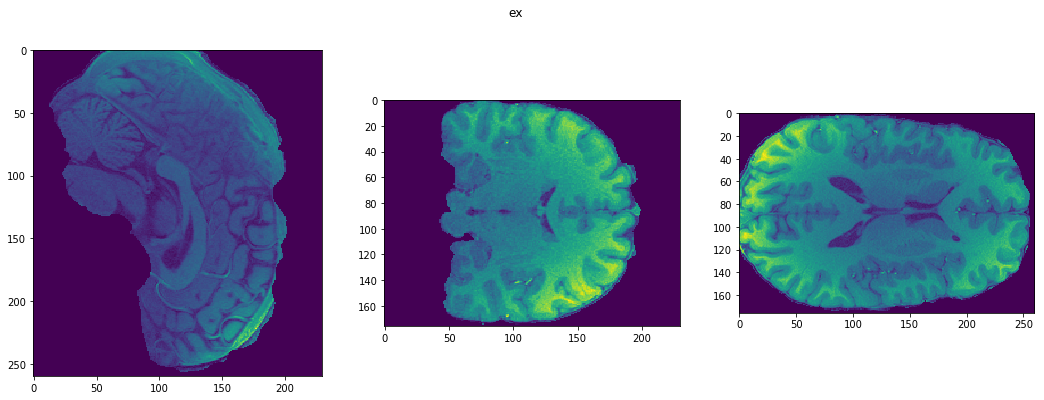

In [5]:
def get_absmax(dataset):
    absmax = 0.
    for (img, target) in dataset:
        img = torch.FloatTensor(img).to(device)
        absmax = max(absmax, img.abs().max().item())
        del img, target
    return absmax

def AbsMaxScale(img, absmax):
    return img / absmax

def plot_central_cuts(img, title="", t=None):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    param image: tensor or np array of shape (TxCxDxHxW) if t is not None
    """
    if t is not None:
        img = img[t]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    fig.suptitle(title)
    axes[0].imshow(img[0, img.shape[1] // 2, :, :])
    axes[1].imshow(img[0, :, img.shape[2] // 2, :])
    axes[2].imshow(img[0, :, :, img.shape[3] // 2])
    plt.show()
    
hcp_dataset = HCP_MRI(
    paths= PATH_TO_MRI,
    target_path= behavioral_path,
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(40,25,55),
    img_shape=(176, 260, 230)
)
hcp_absmax = 435.0126647949219 # get_absmax(la5_dataset)
hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)

transform = Compose([
#     BrightnessContrast(),
#     GaussNoise(),
#     Rotate(),
    ToTensor(),
])
hcp_dataset.transform = transform
print("HCP absmax before normalization: {}".format(hcp_absmax))
print("Dataset size: {}".format(len(hcp_dataset)))
print("Labels distribution: {}\n".format(np.unique(hcp_dataset.labels, return_counts=True)))

print("Example:")
img, target = hcp_dataset[0]
print("Image shape: {}".format(img.shape))
print("Type: {}".format(type(img)))
print("Target: {}".format(target))
plot_central_cuts(img, title="ex", t = None)

In [6]:
# class MriNetGrad(nn.Module):
#     def __init__(self, c):
#         super(MriNetGrad, self).__init__()
#         self.features = nn.Sequential( 
#                 nn.Conv3d(1, c, kernel_size=3),
#                 nn.BatchNorm3d(c),
#                 nn.ReLU(),
#                 nn.MaxPool3d(kernel_size=3),
                
#                 nn.Conv3d(c, 2*c, kernel_size=3),
#                 nn.BatchNorm3d(2*c),
#                 nn.ReLU(),
#                 nn.MaxPool3d(kernel_size=3),
                
#                 nn.Conv3d(2*c, 4*c, kernel_size=3, stride=1, dilation=1, padding=0),
#                 nn.BatchNorm3d(4*c),
#                 nn.ReLU()
#         )
#         self.classifier = nn.Sequential(
#             nn.MaxPool3d(kernel_size=3),
#             nn.Flatten(),
# #             nn.Linear(in_features=4*c*5*5*5, out_features=2),
#             nn.Linear(in_features=35840, out_features=2)
#         )
#         self.gradients = None
        
  
#     def activations_hook(self, grad):
#         self.gradients = grad

#     def forward(self, x):
#         x = self.features(x)
#         h = x.register_hook(self.activations_hook)
#         x = self.classifier(x)
#         return x
    
#     def get_activations_gradient(self):
#         return self.gradients
    
#     def get_activations(self, x):
#         return self.features(x)
    
# torch.manual_seed(1)
# np.random.seed(1)

# c = 32
# model = MriNetGrad(c)

In [7]:
class MriNetGrad(nn.Module):
    def __init__(self, c):
        super(MriNetGrad, self).__init__()
        self.features = nn.Sequential( 
                nn.Conv3d(1, c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3, stride=2,),
                
                nn.Conv3d(c, 2*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(2*c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3, stride=2),
                
                nn.Conv3d(2*c, 4*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(4*c),
                nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1896960, out_features=2), #4*c*5*7*5
        )
        self.gradients = None
        
     
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        h = x.register_hook(self.activations_hook)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features(x)
    
torch.manual_seed(1)
np.random.seed(1)

c = 32
model = MriNetGrad(c)

In [8]:
if torch.cuda.is_available():
  device = torch.device("cuda:2")
else:
  device = torch.device("cpu")

if torch.cuda.device_count() > 1:
      d_ids= [2,3,5,0]
      print("Let's use", d_ids, "GPUs!")
      # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
      model = nn.DataParallel(model, device_ids=d_ids)

Let's use [2, 3, 5, 0] GPUs!


In [9]:
def get_prediction(net, data_loader, device):
    net.eval()
    pred_list = []
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        pred_list.append(out.data.max(1)[1].detach().cpu().numpy()) 
        del data, target,out
    return pred_list

In [10]:
!nvidia-smi

Sun Jan 17 19:13:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:05:00.0 Off |                    0 |
| N/A   32C    P0    33W / 250W |   1427MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:08:00.0 Off |                    0 |
| N/A   27C    P0    33W / 250W |  13460MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [11]:
torch.cuda.empty_cache()

In [12]:
hcp_dataset[0][0].shape[1:]

torch.Size([176, 260, 230])

In [13]:
from tqdm import tqdm

In [14]:
isTrain = True

## Meaningful Perturbations

In [18]:
# from torch.optim import Adam
# loader = torch_data.DataLoader(torch_data.Subset(hcp_dataset, np.arange(2)), batch_size=1, shuffle=False)

# N = len(loader)
# for img,_ in tqdm(loader, total=len(loader)):
# #             print(i)
#             img = img.squeeze(axis=0)
#             C, D, H, W = img.shape
        
#             mask = torch.ones((1, C, D // 4, H // 4, W // 4), requires_grad=True, device=device)
#             optimizer = Adam([mask], lr=0.3, betas=(0.9, 0.99), amsgrad=True)
#             for epoch in range(10):
#                 print(mask)
#                 optimizer.zero_grad()
#                 optimizer.step()
#                 mask.data.clamp_(0, 1)
#                 print(mask)
#             break


  0%|          | 0/2 [00:00<?, ?it/s]

tensor([[[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          ...,

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/mri/.local/lib/python3.5/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



tensor([[[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          ...,

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           

In [15]:
if isTrain:
    model = model.to(device)
    model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model__checkpoints_work_gradcam'), map_location=device))#change path
    model = model.float()
    model.eval()
    loader = torch_data.DataLoader(torch_data.Subset(hcp_dataset, np.arange(2)), batch_size=1, shuffle=False)
    pred = np.concatenate(get_prediction(model, loader, device), axis=0)
    np.save(os.path.join(CHECKPOINTS_DIR,'prediction_full_data'), pred)
    for param in model.parameters():
        param.requires_grad = False
    pertrub = MeanPertrub(device, rep=1, lr=0.01)
    masks_pertrub = pertrub.get_masks(loader, pred, model)                      
    np.save(os.path.join(CHECKPOINTS_DIR,'masks_pertrub_skull_data'), masks_pertrub)
else:
    masks_perturb= np.load(os.path.join(CHECKPOINTS_DIR, 'masks_perturb_skull_data.npy'))

  0%|          | 0/2 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

 50%|█████     | 1/2 [02:40<02:40, 160.45s/it]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

100%|██████████| 2/2 [05:20<00:00, 160.35s/it]


In [ ]:
 masks_pertrub

In [27]:
man_idx = np.arange(len(hcp_dataset.labels))[hcp_dataset.labels==1]
woman_idx = np.arange(len(hcp_dataset.labels))[hcp_dataset.labels==0]
man_masks = masks_pertrub[man_idx]
man_mean_mask = np.mean(man_masks, axis=0)
woman_masks = masks_pertrub[woman_idx]
woman_mean_mask = np.mean(woman_masks, axis=0)
mean_mask = (man_mean_mask + woman_mean_mask)/2

IndexError: index 2 is out of bounds for axis 0 with size 1

In [ ]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(np.clip(mean_mask, a_min=0, a_max=1), affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.55)
plt.show()
fig.savefig('meaningful perturbation.png', bbox_inches='tight')

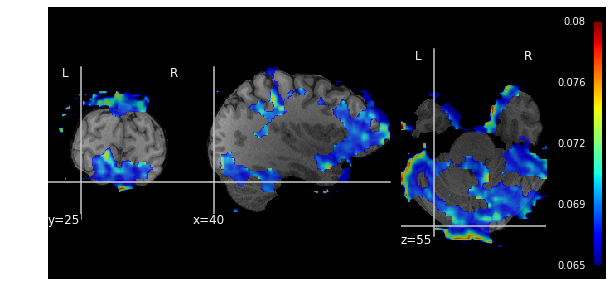

In [23]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(masks_pertrub[1], affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(hcp_dataset[1][0].numpy()),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(40,25,55), axes=axes,colorbar=True,cmap='jet',threshold=0.065)
plt.show()
fig.savefig('mp_skull_rand_female_0_0.065.png', bbox_inches='tight')

In [25]:
bim_img.shape

(176, 260, 230)

In [24]:
roi_img.shape

(176, 260, 230)

In [ ]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(np.clip(mean_mask, a_min=0, a_max=1), affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.55)
plt.show()
fig.savefig('meaningful perturbation.png', bbox_inches='tight')